<a href="https://colab.research.google.com/github/CS20M038/CS6910-assignment_3/blob/main/Attention_without_wandB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Start Creating the Dataset

In [1]:
#@title Import Libraries
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
!pip install wandb
import wandb
from scipy.ndimage.interpolation import shift
import csv
import random

     |████████████████████████████████| 1.8MB 29.5MB/s 
     |████████████████████████████████| 102kB 13.2MB/s 
     |████████████████████████████████| 133kB 53.8MB/s 
     |████████████████████████████████| 174kB 51.2MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=5cb2287963622716a3509272663e4cdc85572745535a1f631b4845129bdeb09b
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=25253cc6d38b84042fb0bd806482f687b657c96644596da723855e100591017f
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [2]:
#@title Check GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
input_dict=['<start>','<end>']
target_dict=['<start>','<end>']
eng_alphabets = 'abcdefghijklmnopqrstuvwxyz'
pad_char = '- PAD-'
eng_alpha2index = {'<start>': 1,'<end>':2}
for index, alpha in enumerate(eng_alphabets):
    eng_alpha2index[alpha] = index+3
    input_dict.append(alpha)

print(eng_alpha2index)
print(input_dict)
# Hindi Unicode Hex Range is 2304:2432. Source: https://en.wikipedia.org/wiki/Devanagari_(Unicode_block)

hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

hindi_alpha2index = {'<start>': 1,'<end>': 2}
#hindi_alpha2index = {'<start>': 0}
for index, alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index+3
    target_dict.append(alpha)
    #print(alpha)

print(hindi_alpha2index)
print(target_dict)



{'<start>': 1, '<end>': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28}
['<start>', '<end>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{'<start>': 1, '<end>': 2, 'ऀ': 3, 'ँ': 4, 'ं': 5, 'ः': 6, 'ऄ': 7, 'अ': 8, 'आ': 9, 'इ': 10, 'ई': 11, 'उ': 12, 'ऊ': 13, 'ऋ': 14, 'ऌ': 15, 'ऍ': 16, 'ऎ': 17, 'ए': 18, 'ऐ': 19, 'ऑ': 20, 'ऒ': 21, 'ओ': 22, 'औ': 23, 'क': 24, 'ख': 25, 'ग': 26, 'घ': 27, 'ङ': 28, 'च': 29, 'छ': 30, 'ज': 31, 'झ': 32, 'ञ': 33, 'ट': 34, 'ठ': 35, 'ड': 36, 'ढ': 37, 'ण': 38, 'त': 39, 'थ': 40, 'द': 41, 'ध': 42, 'न': 43, 'ऩ': 44, 'प': 45, 'फ': 46, 'ब': 47, 'भ': 48, 'म': 49, 'य': 50, 'र': 51, 'ऱ': 52, 'ल': 53, 'ळ': 54, 'ऴ': 55, 'व': 56, 'श': 57, 'ष': 58, 'स': 59, 'ह': 60, 'ऺ': 61, 'ऻ': 62, '़': 63, 'ऽ': 64, 'ा': 65, 'ि': 66,

In [4]:
# Hindi Unicode Hex Range is 2304:2432. Source: https://en.wikipedia.org/wiki/Devanagari_(Unicode_block)

hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

hindi_index2alpha = {1:'<start>',2: '<end>'}
for index, alpha in enumerate(hindi_alphabets):
    hindi_index2alpha[index+3] = alpha
   # target_dict.append(alpha)
    #print(alpha)

print(hindi_index2alpha)

eng_alphabets = 'abcdefghijklmnopqrstuvwxyz'
eng_index2alpha = {1:'<start>',2: '<end>'}
for index, alpha in enumerate(eng_alphabets):
    eng_index2alpha[index+3] = alpha
   # target_dict.append(alpha)
    #print(alpha)

print(eng_index2alpha)

{1: '<start>', 2: '<end>', 3: 'ऀ', 4: 'ँ', 5: 'ं', 6: 'ः', 7: 'ऄ', 8: 'अ', 9: 'आ', 10: 'इ', 11: 'ई', 12: 'उ', 13: 'ऊ', 14: 'ऋ', 15: 'ऌ', 16: 'ऍ', 17: 'ऎ', 18: 'ए', 19: 'ऐ', 20: 'ऑ', 21: 'ऒ', 22: 'ओ', 23: 'औ', 24: 'क', 25: 'ख', 26: 'ग', 27: 'घ', 28: 'ङ', 29: 'च', 30: 'छ', 31: 'ज', 32: 'झ', 33: 'ञ', 34: 'ट', 35: 'ठ', 36: 'ड', 37: 'ढ', 38: 'ण', 39: 'त', 40: 'थ', 41: 'द', 42: 'ध', 43: 'न', 44: 'ऩ', 45: 'प', 46: 'फ', 47: 'ब', 48: 'भ', 49: 'म', 50: 'य', 51: 'र', 52: 'ऱ', 53: 'ल', 54: 'ळ', 55: 'ऴ', 56: 'व', 57: 'श', 58: 'ष', 59: 'स', 60: 'ह', 61: 'ऺ', 62: 'ऻ', 63: '़', 64: 'ऽ', 65: 'ा', 66: 'ि', 67: 'ी', 68: 'ु', 69: 'ू', 70: 'ृ', 71: 'ॄ', 72: 'ॅ', 73: 'ॆ', 74: 'े', 75: 'ै', 76: 'ॉ', 77: 'ॊ', 78: 'ो', 79: 'ौ', 80: '्', 81: 'ॎ', 82: 'ॏ', 83: 'ॐ', 84: '॑', 85: '॒', 86: '॓', 87: '॔', 88: 'ॕ', 89: 'ॖ', 90: 'ॗ', 91: 'क़', 92: 'ख़', 93: 'ग़', 94: 'ज़', 95: 'ड़', 96: 'ढ़', 97: 'फ़', 98: 'य़', 99: 'ॠ', 100: 'ॡ', 101: 'ॢ', 102: 'ॣ', 103: '।', 104: '॥', 105: '०', 106: '१', 107: '२', 108: '३', 109: '४', 110: '५

In [5]:
def readXmlDataset(filename):
        tsv_file = open(filename)
        read_tsv = csv.reader(tsv_file, delimiter="\t")
        lang1_words = []
        lang2_words = []

        for row in read_tsv:
            lang2_words.append(row[0])
            lang1_words.append(row[1])
            #print(row[0])

        return lang1_words, lang2_words
train_input_texts, train_target_texts = readXmlDataset('hi.translit.sampled.train.tsv')
test_input_texts, test_target_texts = readXmlDataset('hi.translit.sampled.test.tsv')
val_input_texts, val_target_texts = readXmlDataset('hi.translit.sampled.dev.tsv')

In [6]:
train_target_texts[0]

'अं'

In [7]:
def word_rep(word, letter2index, device = 'cpu'):
    rep = np.zeros((len(word)+1,  129))
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        rep[letter_index][pos] = 1
    pad_pos = letter2index[pad_char]
    rep[letter_index+1][pad_pos] = 1
    return rep

def gt_rep(word, letter2index, device = 'cpu'):
    gt_rep = np.zeros([len(word)+2], dtype=np.long)
    gt_rep[0]=1
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index+1] = pos
    gt_rep[letter_index+2]= letter2index['<end>']
    return gt_rep
    word_rep('abc',eng_alpha2index).shape
    x=gt_rep('abc',eng_alpha2index)

In [8]:
gt_rep('अं',hindi_alpha2index)

array([1, 8, 5, 2])

In [9]:
def createDataset(dataset,letter2index):
    X_train=[]
    for i,data in enumerate(dataset):
        #print(data)
        X_train.append(gt_rep(data,letter2index))
    X_train = np.array(X_train)
    return X_train

In [10]:
X_train = createDataset(train_input_texts,eng_alpha2index)
y_train = createDataset(train_target_texts,hindi_alpha2index)
X_test = createDataset(test_input_texts,eng_alpha2index)
y_test = createDataset(test_target_texts,hindi_alpha2index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [11]:
X_train

array([array([ 1,  3, 16,  2]),
       array([ 1,  3, 16, 13,  9,  3, 16, 11, 22,  2]),
       array([ 1, 23, 16,  5, 14,  7,  2]), ...,
       array([ 1, 10, 27,  7, 16, 21,  3, 16,  9,  2]),
       array([ 1, 26, 23,  3, 16, 28,  3, 16,  9,  2]),
       array([ 1, 17, 15,  2])], dtype=object)

In [12]:
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]
'''d=one_hot_decode(y_train_padded[5])
c=hindi_index2alpha[6]+hindi_index2alpha[3]+hindi_index2alpha[22]+hindi_index2alpha[66]+hindi_index2alpha[49]+hindi_index2alpha[64]+hindi_index2alpha[37]+hindi_index2alpha[0]
c'''

'd=one_hot_decode(y_train_padded[5])\nc=hindi_index2alpha[6]+hindi_index2alpha[3]+hindi_index2alpha[22]+hindi_index2alpha[66]+hindi_index2alpha[49]+hindi_index2alpha[64]+hindi_index2alpha[37]+hindi_index2alpha[0]\nc'

In [13]:
max_input_sequence= max(len(seq) for seq in X_train)
max_output_sequence= max(len(seq) for seq in y_train)

print('max_input_sequence: ', max_input_sequence)
print('max_output_sequence: ', max_output_sequence)

max_input_sequence:  22
max_output_sequence:  21


In [14]:
from keras.preprocessing.sequence import pad_sequences
X_train_padded = pad_sequences(X_train, maxlen= max_input_sequence, padding='post', value=0)
print("X_train shape: ",X_train.shape)
print("X_train_padded shape: ",X_train_padded.shape)

y_train_padded = pad_sequences(y_train, maxlen= max_output_sequence, padding='post', value=0)
print("y_train shape: ",y_train.shape)
print("y_train_padded shape: ",y_train_padded.shape)

X_train shape:  (44204,)
X_train_padded shape:  (44204, 22)
y_train shape:  (44204,)
y_train_padded shape:  (44204, 21)


In [15]:
X_test_padded = pad_sequences(X_test, maxlen= max_input_sequence, padding='post', 
                              value=0)
print("X_test shape: ",X_test.shape)
print("X_test_padded shape: ",X_test_padded.shape)

y_test_padded = pad_sequences(y_test, maxlen= max_output_sequence, padding='post', 
                              value=0)
print("y_test shape: ",y_test.shape)
print("y_test_padded shape: ",y_test_padded.shape)

X_test shape:  (4502,)
X_test_padded shape:  (4502, 22)
y_test shape:  (4502,)
y_test_padded shape:  (4502, 21)


In [16]:
!pip3 install sklearn
from sklearn.model_selection import train_test_split
input_tensor, target_tensor = X_train_padded, y_train_padded
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.001)

In [17]:
# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [18]:
max_length_targ

21

In [19]:
target_tensor_train[0]

array([ 1, 60, 78, 53, 67,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0], dtype=int32)

In [20]:
# Show the mapping b/w word index and language tokenizer
def convert(lang, tensor):
  for t in tensor:
    if t != 0:
      print ("%d ----> %s" % (t, lang[t]))
      
print ("Input Language; index to word mapping")
convert(eng_index2alpha, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(hindi_index2alpha, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
10 ----> h
17 ----> o
14 ----> l
11 ----> i
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
60 ----> ह
78 ----> ो
53 ----> ल
67 ----> ी
2 ----> <end>


In [21]:
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

44159 44159 45 45


#End creating data set

In [22]:
# Essential model parameters
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 512
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(eng_alpha2index) + 1
vocab_tar_size = len(hindi_alpha2index) + 1

In [23]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [24]:
# Size of input and target batches
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([512, 22]), TensorShape([512, 21]))

In [25]:
# Encoder class
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units

    # Embed the vocab to a dense embedding 
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)

    # GRU Layer
    # glorot_uniform: Initializer for the recurrent_kernel weights matrix, 
    # used for the linear transformation of the recurrent state
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  # Encoder network comprises an Embedding layer followed by a GRU layer
  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state=hidden)
    return output, state

  # To initialize the hidden state
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [26]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (512, 22, 1024)
Encoder Hidden state shape: (batch size, units) (512, 1024)


In [27]:
# Attention Mechanism
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # values shape == (batch_size, max_len, hidden size)

    # we are doing this to broadcast addition along the time axis to calculate the score
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [28]:
attention_layer = BahdanauAttention(25)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (512, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (512, 22, 1)


In [29]:
# Decoder class
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # Used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # x shape == (batch_size, 1)
    # hidden shape == (batch_size, max_length)
    # enc_output shape == (batch_size, max_length, hidden_size)

    # context_vector shape == (batch_size, hidden_size)
    # attention_weights shape == (batch_size, max_length, 1)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [30]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (512, 131)


In [31]:
import numpy as np

# Evaluate function -- similar to the training loop
def evaluate(sentence):

  # Attention plot (to be plotted later on) -- initialized with max_lengths of both target and input
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  '''# Preprocess the sentence given
  sentence = preprocess_sentence(sentence)

  # Fetch the indices concerning the words in the sentence and pad the sequence
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]'''
  inputs = gt_rep(sentence,eng_alpha2index)

  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  # Convert the inputs to tensors
  inputs = tf.convert_to_tensor(inputs)
  #print(inputs.shape)
  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([0], 0)

  # Loop until the max_length is reached for the target lang (ENGLISH)
  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)
    #print(predictions.shape)

    # Store the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    # Get the prediction with the maximum attention
    predicted_id = tf.argmax(predictions[0]).numpy()

    # If <end> token is reached, return the result, input, and attention plot
    if hindi_index2alpha[predicted_id] == '<end>':
      return result, sentence, attention_plot
    # Append the token to the result
    result += hindi_index2alpha[predicted_id]

   

    # The predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [32]:
from matplotlib.font_manager import FontProperties
from pathlib import Path
nirm = Path('/content/Nirmala.ttf')
# configure the Hindi font
hindi_font = FontProperties(fname=nirm)

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.font_manager import FontProperties


hindi_font = FontProperties(fname='Mangal 400.TTF', size=18)


In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(3,3))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  for label in  ax.get_yticklabels():
    label.set_fontproperties(hindi_font)
    label.set_fontsize(15) 

  plt.show()
  return fig

In [34]:
hindi_font

In [35]:
# Translate function (which internally calls the evaluate function)
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  #print('Input: %s' % (sentence))
  #print('Predicted translation: {}'.format(result))

  #attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
 # plot_attention(attention_plot, sentence.split(' '), result.split(' '))
  return result

In [36]:
def split(word):
    return list(word)
# Translate function (which internally calls the evaluate function)
def translate2(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result), :len(sentence)]
  return plot_attention(attention_plot, split(sentence), split(result))
  #return result

In [37]:
def calculate_Sample_Word_accuracy(val_input,val_target,sample_size):
  randomlist = random.sample(range(0, len(val_input)), sample_size)
  # print(randomlist)
  count=0
  start = time.time()
  for i in randomlist:
      result = translate(val_input[i])
      #print("Actual translation",val_target[i])
      if(result==val_target[i]):
          count+=1
  #print('Val Accuracy = : {}'.format(count*100.0/len(randomlist)))
  #print('Time taken for calculating word accuracy {} sec\n'.format(time.time() - start))
  #print("\n")
  #print("\n")
  return count*100.0/len(randomlist)

In [38]:
# Initialize optimizer and loss functions
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# Loss function
def loss_function(real, pred):

  # Take care of the padding. Not all sequences are of equal length.
  # If there's a '0' in the sequence, the loss is being nullified
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [39]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [40]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  # tf.GradientTape() -- record operations for automatic differentiation
  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    # dec_hidden is used by attention, hence is the same enc_hidden
    dec_hidden = enc_hidden

    # <start> token is the initial decoder input
    dec_input = tf.expand_dims([0] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):

      # Pass enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      # Compute the loss
      loss += loss_function(targ[:, t], predictions)

      # Use teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  # As this function is called per batch, compute the batch_loss
  batch_loss = (loss / int(targ.shape[1]))

  # Get the model's variables
  variables = encoder.trainable_variables + decoder.trainable_variables

  # Compute the gradients
  gradients = tape.gradient(loss, variables)

  # Update the variables of the model/network
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [41]:
import time

EPOCHS = 30

# Training loop
for epoch in range(EPOCHS):
  start = time.time()

  # Initialize the hidden state
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  # Loop through the dataset
  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):

    # Call the train method
    batch_loss = train_step(inp, targ, enc_hidden)

    # Compute the loss (per batch)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # Save (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  # Output the loss observed until that epoch
  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  #train_accuracy = calculate_Sample_Word_accuracy(train_input_texts,train_target_texts,250)
  #val_accuracy = calculate_Sample_Word_accuracy(val_input_texts,val_target_texts,250)
  #print('Epoch {} Train_Word_Accuracy {:.4f}'.format(epoch + 1,
                                      #train_accuracy))
  #print('Epoch {} Validation_Word_Accuracy {:.4f}'.format(epoch + 1,
                                      #val_accuracy))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 1.6893
Epoch 1 Loss 1.1299
Time taken for 1 epoch 80.76451182365417 sec

Epoch 2 Batch 0 Loss 0.9729
Epoch 2 Loss 0.9565
Time taken for 1 epoch 60.02194094657898 sec

Epoch 3 Batch 0 Loss 0.9207
Epoch 3 Loss 0.8884
Time taken for 1 epoch 59.92675518989563 sec

Epoch 4 Batch 0 Loss 0.8279
Epoch 4 Loss 0.7506
Time taken for 1 epoch 59.76945471763611 sec

Epoch 5 Batch 0 Loss 0.6228
Epoch 5 Loss 0.4436
Time taken for 1 epoch 59.67860794067383 sec

Epoch 6 Batch 0 Loss 0.2933
Epoch 6 Loss 0.2424
Time taken for 1 epoch 59.73726224899292 sec

Epoch 7 Batch 0 Loss 0.1861
Epoch 7 Loss 0.1848
Time taken for 1 epoch 59.93637251853943 sec

Epoch 8 Batch 0 Loss 0.1576
Epoch 8 Loss 0.1564
Time taken for 1 epoch 59.81557893753052 sec

Epoch 9 Batch 0 Loss 0.1464
Epoch 9 Loss 0.1372
Time taken for 1 epoch 59.549299240112305 sec

Epoch 10 Batch 0 Loss 0.1145
Epoch 10 Loss 0.1222
Time taken for 1 epoch 59.928650856018066 sec

Epoch 11 Batch 0 Loss 0.1049
Epoch 11 Loss 0.1088
Time t

In [42]:
# Restore the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: raam
Predicted translation: राम


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text(s, 0.0, flags=flags)


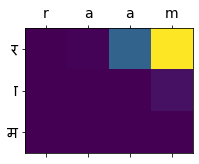

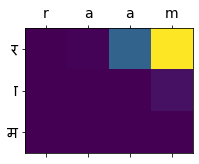

In [43]:
translate2("raam")

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text(s, 0.0, flags=flags)


Input: saurabh
Predicted translation: सौरभ


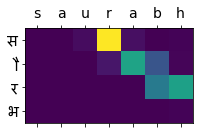

In [44]:
fig1 = translate2("saurabh")

In [45]:
wandb.login()
wandb.init(project = "Assignment 3 Part 2", entity = "cs20m038")
wandb.log({"H1":[wandb.Image(fig1, caption = "Heat Map for saurabh") ]})

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cs20m038 (use `wandb login --relogin` to force relogin)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text(s, 0.0, flags=flags)


In [46]:
accuracy=calculate_Sample_Word_accuracy(val_input_texts,val_target_texts,100)
accuracy

34.0

In [47]:
import pandas as pd
def calculate_Test_wordAccuracy(input_text,target_text):
    start = time.time()
    predicted_words=[]
    count=0
    for (i,sentence) in enumerate(input_text):
        print(sentence)
        result = translate(sentence)
        predicted_words.append(result)
        print("Actual translation",target_text[i])
        print("Predicted translation",result)
        if result==target_text[i]:
            count+=1
    print('Word Accuracy = : {}'.format(count*100.0/len(input_text)))
    print('Time taken for 1calculating word accuracy {} sec\n'.format(time.time() - start))
    (pd.DataFrame({'English Word': input_text, 'True Transliteration': target_text, 'Predicted Transliteration': predicted_words})
   .to_csv('results_attn.csv', index=False))
    return count*100.0/len(input_text)


In [48]:
acc=calculate_Test_wordAccuracy(test_input_texts,test_target_texts)
acc

Streaming output truncated to the last 5000 lines.
Actual translation बीफ
Predicted translation बीफ
beem
Actual translation बीम
Predicted translation बीम
bim
Actual translation बीम
Predicted translation बीम
beemon
Actual translation बीमों
Predicted translation बीमोन
bimon
Actual translation बीमों
Predicted translation बाइमन
beerganj
Actual translation बीरगंज
Predicted translation बीरगंज
birganj
Actual translation बीरगंज
Predicted translation बर्गंज
beesavaan
Actual translation बीसवां
Predicted translation बीसवान
bisavan
Actual translation बीसवां
Predicted translation बीसवन
bisawan
Actual translation बीसवां
Predicted translation बीसवन
beast
Actual translation बीस्ट
Predicted translation बीअस्ट
budvig
Actual translation बुडविग
Predicted translation बुदविग
budwig
Actual translation बुडविग
Predicted translation बुडविग
bull
Actual translation बुल
Predicted translation बुल
bulaao
Actual translation बुलाओ
Predicted translation बुलाओ
bulao
Actual translation बुलाओ
Predicted translation बुलाओ
b

41.20390937361173

In [49]:
str(2)

'2'

#Attention Heat Map for 10 test data

Input: chanwal
Predicted translation: चनवाल


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text(s, 0.0, flags=flags)


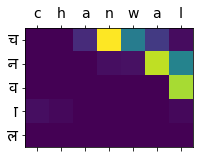

Input: rajinama
Predicted translation: राजिनामा


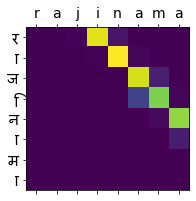

Input: subhaay
Predicted translation: सुभाय


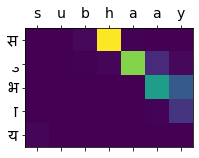

Input: naagrik
Predicted translation: नागरिक


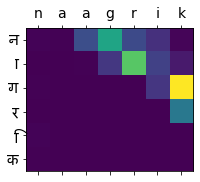

Input: nelson
Predicted translation: नेल्सन


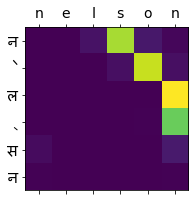

Input: ghumakkdon
Predicted translation: घूमक्कड़ों


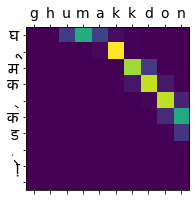

Input: pmo
Predicted translation: प्मो


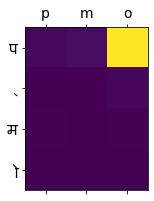

Input: shervasiyon
Predicted translation: शेरवासियों


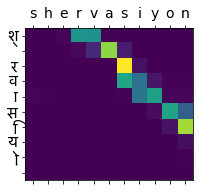

Input: fawaara
Predicted translation: फवारा


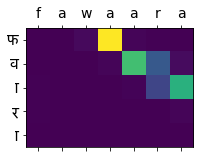

Input: parshdon
Predicted translation: पारश्दों


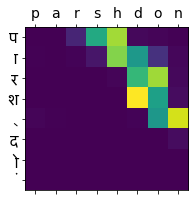

In [50]:
randomlist = random.sample(range(0, len(test_input_texts)), 10)
randomlist
for i in randomlist:
      figure = translate2(test_input_texts[i])
      wandb.log({"Heatmap"+str(i):[wandb.Image(figure, caption = "Heat Map for word"+str(i)) ]})
      

In [51]:
import pandas as pd

def calculate_Test_wordAccuracy(input_text,target_text):
    start = time.time()
    predicted_words=[]
    count=0
    for (i,sentence) in enumerate(input_text):
       # print(sentence)
        result = translate(sentence)
        predicted_words.append(result)
        #print("Actual translation",target_text[i])
        #print("Predicted translation",result)
        if result==target_text[i]:
            count+=1
    print('Word Accuracy = : {}'.format(count*100.0/len(input_text)))
    print('Time taken for 1calculating word accuracy {} sec\n'.format(time.time() - start))
    (pd.DataFrame({'English Word': input_text, 'True Transliteration': target_text, 'Predicted Transliteration': predicted_words})
   .to_csv('results_attn.csv', index=False))
    return count*100.0/len(input_text)


#Visualistaion of Attentions

In [52]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

In [53]:
def attention_color(attention_score):
    c = 255 - int(attention_score * 255)
    color = rgb_to_hex((c,255,c))
    return str(color)

In [54]:
from IPython.core.display import display, HTML

In [55]:
from numpy import exp
# calculate the softmax of a vector
def softmax(vector):
	e = exp(vector)
	return e / e.sum(axis=0)

In [56]:
def visulize_prediction(input_word):
    result, sentence, attention_plot=evaluate(input_word)
    
    print(sentence)
    print(result)
    attention_plot_1 = attention_plot[0:len(result), 0:len(sentence)]
    #attentions=attention_plot_1[:,1]
    #ls=softmax(attention_plot_1.T).T
    ls=softmax(attention_plot_1)
    #ls=attention_plot_1
    print(ls.shape)

    b=split(sentence)

    a=split(result)
   # b.insert(0,'<start>')
    #a.insert(0,'<start>')
    #b.insert(len(b),'<end>')
    #a.insert(len(a),'<end>')
    print("input word",b)
    print("predicted word",a)
    tokenized_sample=b
    attentions=ls

    for j in range(len(a)):
        print(a[j])
        token_attention_dic = {}
        max_score = 0.0
        min_score = 0.0
        attentions=ls[j]
        key_to_char_dic={}
        '''for token, attention_score in zip(tokenized_sample, attentions[2]):
            token_attention_dic[token] = attention_score'''
        maximum = 0
        max_id=0
        for i in range(len(tokenized_sample)):
            key_to_char_dic[i]=tokenized_sample[i]
            token_attention_dic[i] = attentions[i]
            if maximum< attentions[i]:
                maximum=attentions[i]
                max_id=i

        #print(token_attention_dic)
        #print(key_to_char_dic)
        #html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
        html_text =""
        for word, att in token_attention_dic.items():
            if word==max_id :
                att=att+0.2

            html_text += "<span style='background-color:{};'>{} <span> ".format(attention_color(att), key_to_char_dic[word])
        html_text += "</p>"
        display(HTML(html_text))
   


In [57]:
visulize_prediction("parshuram")

parshuram
परशुराम
(7, 9)
input word ['p', 'a', 'r', 's', 'h', 'u', 'r', 'a', 'm']
predicted word ['प', 'र', 'श', 'ु', 'र', 'ा', 'म']
प


र


श


ु


र


ा


म


In [58]:
visulize_prediction("anaavashyak")

anaavashyak
अनावश्यक
(8, 11)
input word ['a', 'n', 'a', 'a', 'v', 'a', 's', 'h', 'y', 'a', 'k']
predicted word ['अ', 'न', 'ा', 'व', 'श', '्', 'य', 'क']
अ


न


ा


व


श


्


य


क


In [59]:
visulize_prediction("ank")

ank
अंक
(3, 3)
input word ['a', 'n', 'k']
predicted word ['अ', 'ं', 'क']
अ


ं


क


#Visualization Method 2

In [60]:
result, sentence, attention_plot=evaluate("rag")
    
print(sentence)
print(result)
attention_plot_1 = attention_plot[0:len(result), 0:len(sentence)]
#attentions=attention_plot_1[:,1]
#ls=softmax(attention_plot_1.T).T
ls=softmax(attention_plot_1)
ls=(ls == ls.max(axis=1)[:,None]).astype(int)
#ls=attention_plot_1
print(ls.shape)

b=split(sentence)

a=split(result)
# b.insert(0,'<start>')
#a.insert(0,'<start>')
#b.insert(len(b),'<end>')
#a.insert(len(a),'<end>')
print("input word",b)
print("predicted word",a)
tokenized_sample=b

rag
रग
(2, 3)
input word ['r', 'a', 'g']
predicted word ['र', 'ग']


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 108 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 112 missing from current font.
  font.set_text(s, 0.0, flags=flags)
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2327 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 2352 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183

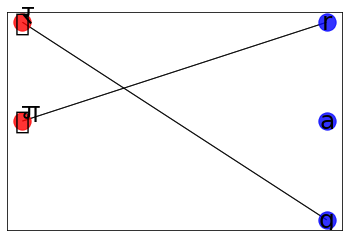

In [61]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import matching
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['font.sans-serif'] = ['Source Han Sans TW',
                                   'sans-serif',
                                   "Arial Unicode MS"  # fc-list :lang=hi family
                                   ]


'''ls=[
[0,0,0,1,1],
[1,0,0,0,0],
[1,0,1,0,0],
]'''

g = nx.Graph()
#a=['a'+str(i) for i in range(len(ls))]
#b=['b'+str(j) for j in range(len(ls[0]))]
g.add_nodes_from(a,bipartite=0)
g.add_nodes_from(b,bipartite=1)

for i in range(len(ls)):
    for j in range(len(ls[i])):
        if ls[i][j] != 0:
            g.add_edge(a[i], b[j])
pos_a={}
x=0.100
const=0.100
y=1.0
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
prop = fm.FontProperties(fname='/content/Mangal 400.TTF', size=25)
for i in range(len(a)):
    pos_a[a[i]]=[x,y-i*const]
    plt.text(x, y-i*const,a[i] , fontproperties=prop)

xb=0.500
pos_b={}
for i in range(len(b)):
    pos_b[b[i]]=[xb,y-i*const]
    

nx.draw_networkx_nodes(g,pos_a,nodelist=a,node_color='r',node_size=300,alpha=0.8)
nx.draw_networkx_nodes(g,pos_b,nodelist=b,node_color='b',node_size=300,alpha=0.8)

# edges
pos={}
pos.update(pos_a)
pos.update(pos_b)

nx.draw_networkx_edges(g,pos,edgelist=nx.edges(g),width=1,alpha=0.8,edge_cmap=plt.cm.Blues)

nx.draw_networkx_labels(g,pos,font_size=25,font_family='sans-serif')
m=matching.maximal_matching(g)
nx.draw_networkx_edges(g,pos,edgelist=m,width=1,alpha=0.8,edge_cmap=plt.cm.Blues)



plt.show()

#Visualization Method 3 using inbuilt functions from open source project

In [62]:
pip install nmtvis

     |████████████████████████████████| 5.2MB 26.7MB/s 


In [63]:
from nmtvis.AttentionVisualizer import visualize_attention
import json

#Create JSon file to be usedin the visualiza attention function

In [64]:
def get_dict(input_word):
    #input_word = "ramliala"
    result, sentence, attention_plot=evaluate(input_word)
    sentence
    ss=split(sentence)
    ts=split(result)
    attention_plot_1 = attention_plot[0:len(result), 0:len(sentence)]
    am=softmax(attention_plot_1.T).T
    dictn1 = {"source_sentence":ss,"target_sentence":ts,'attention_matrix':am.tolist()}
    return dictn1

#Visualizing random  1000 Test Data

In [65]:
dict_list=[]
randomlist = random.sample(range(0, len(test_input_texts)), 1000)
for i in randomlist:
    dict_list.append(get_dict(test_input_texts[i]))
with open("JsonTest", "w") as fp:
    json.dump(dict_list,fp,indent=4)

#Put the JsonFile created above in the working directory

#install nmtvis using 
#pip install nmtvis
#on to your local machine 
#Then make a python script written below in notepad with name visualization.py

```
# Script for visualization.py

from nmtvis.AttentionVisualizer import visualize_attention
import json

with open("JsonTest", 'r') as f:
    data = json.load(f)

print(type(data))
print(data[0].keys())

visualize_attention(data)

```
#Then run the scripy using 
#python visulization.py
#from any terminal like vscode 
#You will be automatically directed to a local server which will open in your default browser and will we be able to see three kind of visulisation like allignment view, HeatMap,Higlisht Graph.Its awesome try this

In [67]:
vocab_tar_size

131